# Component Separation on CMB S4 and QUBIC+

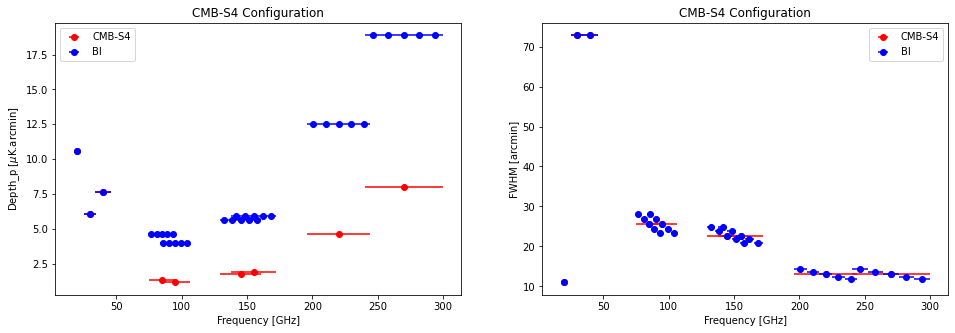

In [12]:
import qubicplus
import CMBS4
import pysm3
import pysm3.units as u
from pysm3 import utils
import numpy as np
from qubic import camb_interface as qc
import healpy as hp
import matplotlib.pyplot as plt
import os
import random as rd
import string
import qubic
from importlib import reload
import pickle
import s4bi

center = qubic.equ2gal(0, -57)
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

nside=256
def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap_q = hp.ud_grade(hp.read_map('QUBIC-Typical-Coverage.fits'), 256)
covmap = get_coverage(0.03, nside)


thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

#from fgbuster import (separation_recipes, xForecast, CMB, Dust, Dust_2b, Synchrotron, FreeFree, PowerLaw,  # sky-fitting model
                      #basic_comp_sep)
import fgbuster as fgb
from fgbuster import basic_comp_sep, get_instrument


def separate(comp, instr, maps_to_separate, tol=1e-5, print_option=False):
    solver_options = {}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'Nelder-Mead', 'tol': tol, 'options': solver_options}
    try:
        res = fgb.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgb.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res


def reconvolve(maps, fwhms, ref_fwhm, verbose=False):
    if verbose:
        print('Reconvolution to common FWHM')
    sig_conv = np.sqrt(ref_fwhm**2 - fwhms**2)
    maps_out = np.zeros_like(maps)
    for i in range(len(fwhms)):
        if sig_conv[i] == 0:
            if verbose:
                print('Map {0:} fwhmin={1:6.3f} fwhmout={2:6.3f} => We do not reconvolve'.format(i,
                                                                                             fwhms[i], ref_fwhm))
            maps_out[i,:] = maps[i,:]
        else:
            if verbose:
                print('Map {0:} fwhmin={1:6.3f} fwhmout={2:6.3f} => We reconvolve with {3:6.3f}'.format(i,
                                                                                                    fwhms[i],
                                                                                                    ref_fwhm,
                                                                                                    sig_conv[i]))
            maps_out[i,:] = hp.smoothing(maps[i,:], fwhm=np.deg2rad(sig_conv[i]), pol=True, verbose=False)
    return maps_out



# Loading of dictionary from BI-CMBS4.ipynb 

### CMB-S4 config

freqs = np.array([20., 30., 40., 85., 95., 145., 155., 220., 270.])
bandwidth = np.array([5., 9., 12., 20.4, 22.8, 31.9, 34.1, 48.4, 59.4])
dnu_nu = bandwidth/freqs
beam_fwhm = np.array([11., 72.8, 72.8, 25.5, 25.5, 22.7, 22.7, 13., 13.])
mukarcmin_TT = np.array([16.5, 9.36, 11.85, 2.02, 1.78, 3.89, 4.16, 10.15, 17.4])
mukarcmin_EE = np.array([10.87, 6.2, 7.85, 1.34, 1.18, 1.8, 1.93, 4.71, 8.08])
mukarcmin_BB = np.array([10.23, 5.85, 7.4, 1.27, 1.12, 1.76, 1.89, 4.6, 7.89])
ell_min = np.array([30, 30, 30, 30, 30, 30, 30, 30, 30])
nside = np.array([512, 512, 512, 512, 512, 512, 512, 512, 512])
edges_min = freqs * (1. - dnu_nu/2)
edges_max = freqs * (1. + dnu_nu/2)
edges = [[edges_min[i], edges_max[i]] for i in range(len(freqs))]
s4_config = {
    'nbands': len(freqs),
    'frequency': freqs,
    'depth_p': 0.5*(mukarcmin_EE + mukarcmin_BB),
    'depth_i': mukarcmin_TT,
    'depth_e': mukarcmin_EE,
    'depth_b': mukarcmin_BB,
    'fwhm': beam_fwhm,
    'bandwidth': bandwidth,
    'dnu_nu': dnu_nu,
    'ell_min': ell_min,
    'nside': nside,
    'fsky': 0.03,
    'ntubes': 12,
    'nyears': 7.,
    'edges': edges,
    'effective_fraction': np.zeros(len(freqs))+1.
            }

def fct_subopt(nus):
    subnus = [150., 220]
    subval = [1.4, 1.2]
    fct_subopt = np.poly1d(np.polyfit(subnus, subval, 1))
    return fct_subopt(nus)

subnus = [150., 220]
subval = [1.4, 1.2]

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

def qubicify(config, qp_nsub, qp_effective_fraction):
    nbands = np.sum(qp_nsubs)
    qp_config = config.copy()
    for k in qp_config.keys():
        qp_config[k]=[]
    qp_config['nbands'] = nbands
    qp_config['fsky'] = config['fsky']
    qp_config['ntubes'] = config['ntubes']
    qp_config['nyears'] = config['nyears']
    qp_config['initial_band'] = []

    for i in range(len(config['frequency'])):
        #print(config['edges'][i][0], config['edges'][i][-1])
        newedges = np.linspace(config['edges'][i][0], config['edges'][i][-1], qp_nsubs[i]+1)
        #print(newedges)
        newfreqs = (newedges[0:-1]+newedges[1:])/2
        newbandwidth = newedges[1:] - newedges[0:-1]
        newdnu_nu = newbandwidth / newfreqs
        newfwhm = config['fwhm'][i] * config['frequency'][i]/newfreqs
        scalefactor_noise = np.sqrt(qp_nsubs[i]) * fct_subopt(config['frequency'][i]) / qp_effective_fraction[i]
        newdepth_p = config['depth_p'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_i = config['depth_i'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_e = config['depth_e'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_b = config['depth_b'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newell_min = np.ones(qp_nsub[i]) * config['ell_min'][i]
        newnside = np.ones(qp_nsub[i]) * config['nside'][i]
        neweffective_fraction = np.ones(qp_nsub[i]) * qp_effective_fraction[i]
        initial_band = np.ones(qp_nsub[i]) * config['frequency'][i]

        for k in range(qp_nsubs[i]):
            if qp_effective_fraction[i] != 0:
                qp_config['frequency'].append(newfreqs[k])
                if i >= 3:
                    qp_config['depth_p'].append(newdepth_p[k])
                    qp_config['depth_i'].append(newdepth_i[k])
                    qp_config['depth_e'].append(newdepth_e[k])
                    qp_config['depth_b'].append(newdepth_b[k])
                else:
                    qp_config['depth_p'].append(s4_config['depth_p'][i])
                    qp_config['depth_i'].append(s4_config['depth_i'][i])
                    qp_config['depth_e'].append(s4_config['depth_e'][i])
                    qp_config['depth_b'].append(s4_config['depth_b'][i])
                qp_config['fwhm'].append(newfwhm[k])
                qp_config['bandwidth'].append(newbandwidth[k])
                qp_config['dnu_nu'].append(newdnu_nu[k])
                qp_config['ell_min'].append(newell_min[k])
                qp_config['nside'].append(newnside[k])

                qp_config['effective_fraction'].append(neweffective_fraction[k])
                qp_config['initial_band'].append(initial_band[k])
        for k in range(qp_nsubs[i]+1):
            if qp_effective_fraction[i] != 0:
                qp_config['edges'].append(newedges[k])

        #qp_config['depth_p'][:3] = s4_config['depth_p'][:3]
        #qp_config['depth_i'][:3] = s4_config['depth_i'][:3]

    fields = ['frequency', 'depth_p', 'depth_i', 'depth_e', 'depth_b', 'fwhm', 'bandwidth',
              'dnu_nu', 'ell_min', 'nside', 'edges', 'effective_fraction', 'initial_band']
    for j in range(len(fields)):
        qp_config[fields[j]] = np.array(qp_config[fields[j]])

    return qp_config


covmap = get_coverage(0.03, nside=256)
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0


qp_nsubs = np.array([1, 1, 1, 5, 5, 5, 5, 5, 5])
qp_effective_fraction = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
qp_config=qubicify(s4_config, qp_nsubs, qp_effective_fraction)


plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.errorbar(s4_config['frequency'], s4_config['depth_p'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['depth_p'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Depth_p [$\mu$K.arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.subplot(1,2,2)
plt.errorbar(s4_config['frequency'], s4_config['fwhm'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['fwhm'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel('FWHM [arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.show()

# CMB-S4 case

In [59]:
reload(qubicplus)

ref_fwhm=0
skyconfig = {'cmb':42, 'dust':'d0'}

# Computation of maps for CMB-S4 -> (9, 3, npix)

## We put maps at same resolution (0.5 degree) and with noise factor of 10

mapS4_noisy, mapS4_noiseless, noiseS4 = qubicplus.BImaps(skyconfig, s4_config).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.)

    FWHM : [0. 0. 0. 0. 0. 0. 0. 0. 0.] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Model : d0


# QUBIC+ case

In [60]:
mapqp_noisy, mapqp_noiseless, noiseqp = qubicplus.BImaps(skyconfig, qp_config).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.)

    FWHM : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] deg 
    nus : [ 20.    30.    40.    76.84  80.92  85.    89.08  93.16  85.88  90.44
  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76 141.36 148.18
 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36 246.24 258.12
 270.   281.88 293.76] GHz 
    Bandwidth : [ 5.    9.   12.    4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Model : d0


In [63]:
comp = [fgb.component_model.Dust(nu0=145., temp=20), fgb.component_model.CMB()]

thr = 0
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

# QUBIC+
instr = get_instrument('Qubic+')
instr.fwhm = np.ones(33)*ref_fwhm*60


r_qp=separate(comp, instr, mapqp_noisy[:, :, pixok], tol=1e-6)

# CMB-S4
instr = get_instrument('CMBS4')
instr.fwhm = np.ones(9)*ref_fwhm*60
r_s4=separate(comp, instr, mapS4_noisy[:, :, pixok], tol=1e-6)

print('QUBIC+ -> beta_d = {:.6f}'.format(r_qp.x[0]))
print('CMB-S4 -> beta_d = {:.6f}'.format(r_s4.x[0]))

QUBIC+ -> beta_d = 1.540904
CMB-S4 -> beta_d = 1.539562


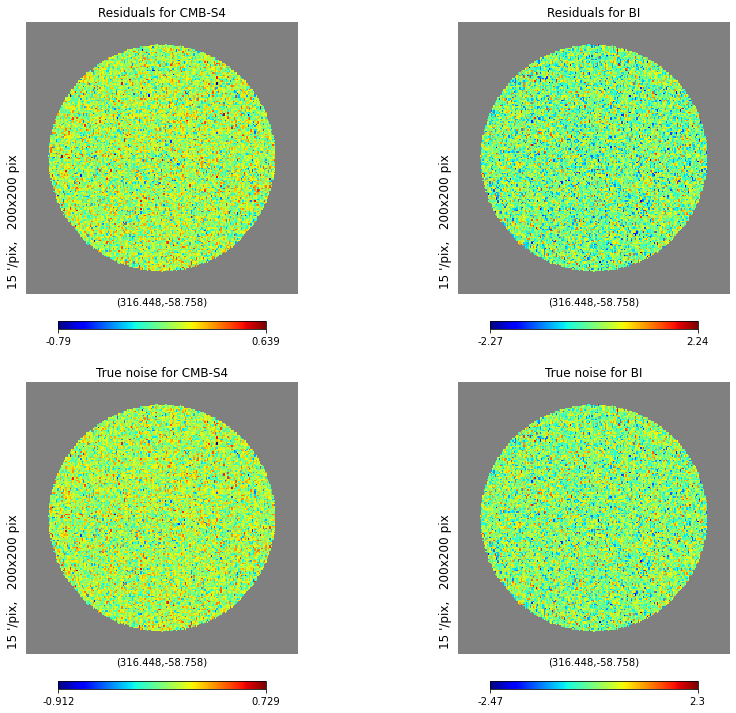

In [71]:
# Residuals

istk=2

mapres_qp = np.ones((3, 12*256**2))*hp.UNSEEN
mapres_qp[:, pixok] = mapqp_noisy[15,:,pixok].T - r_qp.s[0] - r_qp.s[1]
resqp=mapres_qp[istk]
resqp[~pixok]=hp.UNSEEN

mapres_s4 = np.ones((3, 12*256**2))*hp.UNSEEN
mapres_s4[:, pixok] = mapS4_noisy[5,:,pixok].T - r_s4.s[0] - r_s4.s[1]
resS4=mapres_s4[istk]
resS4[~pixok]=hp.UNSEEN


plt.figure(figsize=(12, 10))
hp.gnomview(resS4, rot=center, reso=15, sub=(2, 2, 1), title='Residuals for CMB-S4', 
                                                                    cmap='jet')
hp.gnomview(resqp, rot=center, reso=15, sub=(2, 2, 2), title='Residuals for BI', 
                                                                    cmap='jet')

hp.gnomview(noiseS4[5, istk], rot=center, reso=15, sub=(2, 2, 3), title='True noise for CMB-S4', 
                                                                    cmap='jet')
hp.gnomview(noiseqp[15, istk], rot=center, reso=15, sub=(2, 2, 4), title='True noise for BI', 
                                                                    cmap='jet')
plt.show()

# 2 betas

In [72]:
reload(qubicplus)

ref_fwhm=0
skyconfig = {'cmb':42, 'dust':'d02b'}
nubreak=260

# Computation of maps for CMB-S4 -> (9, 3, npix)

## We put maps at same resolution (0.5 degree) and with noise factor of 10

mapS4_noisy, mapS4_noiseless, noiseS4 = qubicplus.BImaps(skyconfig, s4_config).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.,
                                                                    beta=[1.44, 1.74, nubreak, 145])

    FWHM : [0. 0. 0. 0. 0. 0. 0. 0. 0.] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Model : d02b -> Twos spectral index beta (1.44 and 1.74) with nu_break = 260.00


In [73]:
mapqp_noisy, mapqp_noiseless, noiseqp = qubicplus.BImaps(skyconfig, qp_config).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.,
                                                                    beta=[1.44, 1.74, nubreak, 145])

    FWHM : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] deg 
    nus : [ 20.    30.    40.    76.84  80.92  85.    89.08  93.16  85.88  90.44
  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76 141.36 148.18
 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36 246.24 258.12
 270.   281.88 293.76] GHz 
    Bandwidth : [ 5.    9.   12.    4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Model : d02b -> Twos spectral index beta (1.44 and 1.74) with nu_break = 260.00


In [74]:
comp = [fgb.component_model.Dust_2b(nu0=145.), fgb.component_model.CMB()]

thr = 0
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

# QUBIC+
instr = get_instrument('Qubic+')
instr.frequency = qp_config['frequency']
instr.fwhm = np.ones(33)*ref_fwhm*60
instr.depth_i = qp_config['depth_i']
instr.depth_p = qp_config['depth_p']


r_qp=separate(comp, instr, mapqp_noisy[:, :, pixok], tol=1e-6)

# CMB-S4
instr = get_instrument('CMBS4')
instr.fwhm = np.ones(9)*ref_fwhm*60
r_s4=separate(comp, instr, mapS4_noisy[:, :, pixok], tol=1e-6)

In [75]:
print('True   -> betad0 : {:.6f}, betad1 : {:.6f}, nubreak : {:.6f}, T : {:.6f}\n'.format(1.44, 1.74, nubreak, 20))
print('BI-S4 -> betad0 : {:.6f}, betad1 : {:.6f}, nubreak : {:.6f}, T : {:.6f}\n'.format(r_qp.x[0], r_qp.x[1], r_qp.x[2], r_qp.x[3]))
print('CMB-S4 -> betad0 : {:.6f}, betad1 : {:.6f}, nubreak : {:.6f}, T : {:.6f}'.format(r_s4.x[0], r_s4.x[1], r_s4.x[2], r_s4.x[3]))

True   -> betad0 : 1.440000, betad1 : 1.740000, nubreak : 260.000000, T : 20.000000

BI-S4 -> betad0 : 1.442001, betad1 : 1.744376, nubreak : 260.172250, T : 19.878062

CMB-S4 -> betad0 : 1.446263, betad1 : 1.514839, nubreak : 227.987462, T : 19.581581


In [76]:
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from scipy import constants

def eval_scaled_dust_dbmmb_map(nu_ref, nu_test, beta0, beta1, nubreak, nside, fsky, radec_center, temp):
    #def double-beta dust model
    analytic_expr = s4bi.double_beta_dust_FGB_Model()
    dbdust = AnalyticComponent(analytic_expr, nu0=nu_ref, h_over_k=constants.h * 1e9 / constants.k, temp=temp)
    scaling_factor = dbdust.eval(nu_test, beta0, beta1, nubreak)

    sky=pysm3.Sky(nside=nside, preset_strings=['d0'])
    dust_map_ref = np.zeros((3, 12*nside**2)) #this way the output is w/0 units!!
    dust_map_ref[0:3,:]=sky.get_emission(nu_ref*u.GHz, None)*utils.bandpass_unit_conversion(nu_ref*u.GHz,None, u.uK_CMB)


    map_test=dust_map_ref*scaling_factor

    #mask = s4bi.get_coverage(fsky, nside, center_radec=radec_center)

    return map_test

def get_scaled_dust_dbmmb_map(nu_ref, nu_vec, beta0, beta1, nubreak, nside, fsky, radec_center, temp):
    #eval at each freq. In this way it can be called both in the single-freq and the multi-freq case
    n_nu=len(nu_vec)
    dust_map= np.zeros((n_nu, 3, 12*nside**2))
    for i in range(n_nu):
        map_eval=eval_scaled_dust_dbmmb_map(nu_ref, nu_vec[i], beta0, beta1, nubreak, nside, fsky, radec_center, temp)
        #hp.mollview(map_eval[1])
        dust_map[i,:,:]=map_eval[:,:]
    return dust_map

In [77]:
new_dust_maps_qp=get_scaled_dust_dbmmb_map(145, [145], r_qp.x[0], r_qp.x[1], r_qp.x[2], 256, 0.03, 
                                                        radec_center=[0., -57.], temp=r_qp.x[3])

new_dust_maps_s4=get_scaled_dust_dbmmb_map(145, [145], r_s4.x[0], r_s4.x[1], r_s4.x[2], 256, 0.03, 
                                                        radec_center=[0., -57.], temp=r_s4.x[3])

new_dust_maps_qp[0] = hp.sphtfunc.smoothing(new_dust_maps_qp[0, :, :], fwhm=np.deg2rad(ref_fwhm),verbose=False)
new_dust_maps_s4[0] = hp.sphtfunc.smoothing(new_dust_maps_s4[0, :, :], fwhm=np.deg2rad(ref_fwhm),verbose=False)

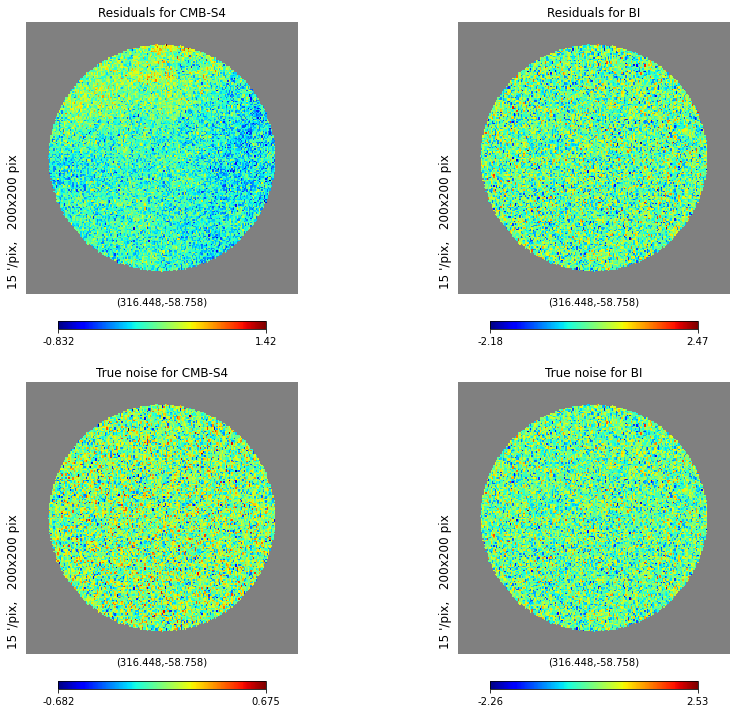

In [79]:
# Residuals

istk=1

mapres_qp = np.ones((3, 12*256**2))*hp.UNSEEN
mapres_qp[:, pixok] = mapqp_noisy[15,:,pixok].T - r_qp.s[1] - new_dust_maps_qp[0, :, pixok].T
resqp=mapres_qp[istk]
resqp[~pixok]=hp.UNSEEN

mapres_s4 = np.ones((3, 12*256**2))*hp.UNSEEN
mapres_s4[:, pixok] = mapS4_noisy[5,:,pixok].T - r_s4.s[1] - new_dust_maps_s4[0, :, pixok].T
resS4=mapres_s4[istk]
resS4[~pixok]=hp.UNSEEN


plt.figure(figsize=(12, 10))
hp.gnomview(resS4, rot=center, reso=15, sub=(2, 2, 1), title='Residuals for CMB-S4', cmap='jet')
hp.gnomview(resqp, rot=center, reso=15, sub=(2, 2, 2), title='Residuals for BI', cmap='jet')

hp.gnomview(noiseS4[5, istk], rot=center, reso=15, sub=(2, 2, 3), title='True noise for CMB-S4', cmap='jet')
hp.gnomview(noiseqp[15, istk], rot=center, reso=15, sub=(2, 2, 4), title='True noise for BI',cmap='jet')
plt.show()